In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from copy import deepcopy
import sys
%matplotlib inline
from matplotlib import pyplot as plt

### Task 1: Daily Temperature Forecasts
In this task you need to build sequence-to-sequence model for temperature forecast using RNN and LSTM.

**a)** Import daily temperature dataset **daily-minimum-temperatures.csv** in the data folder. 

In [2]:
temp_data = pd.read_csv('./data/daily-minimum-temperatures.csv',header=0, index_col=0)
temp_data.head(10)

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8
1981-01-07,15.8
1981-01-08,17.4
1981-01-09,21.8


**b)** Scale the training and test data set using MinMaxScaler

In [3]:
test_length = 50
train, test = temp_data[:-test_length], temp_data[-test_length:]

scaler = MinMaxScaler()
# Scaling the train and test data using minmaxscaler
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

**c)** Build sequence-to-sequence data. For example, the length of the input and target sequence is 4 time steps, i.e.:

        The raw data: [1,2,3,4,5,6,7,8,9,10,...]

                              Prediction
        Input Sequence      -------------->      Target Sequence
          [1,2,3,4]                                [5,6,7,8]
          [2,3,4,5]                                [6,7,8,9]

In [4]:
import numpy as np


def seq_2_seq(data, length_x, length_y):
    '''
    convert the input data to seq-to-seq samples for training rnn model.
    
    Inputs:
    data: pd.DataFrame, the input temperature data set.
    length_x: The length of the input sequence
    length_y: The length of the output sequence
    
    Outputs:
    X: Input sequence, the size is: [number of samples, length_x, features]
    y: Output sequence, the size is: [number of samples, length_y, features]
    '''
    X = []
    y = []
    for i in range(len(data) - length_x - length_y):
        X.append(data[i:i+length_x])
        y.append(data[i+length_x:i+length_x+length_y])
    return np.array(X), np.array(y)

In [5]:
# Input sequence size:  (num_sample, 7, 1)
# Target sequence size: (num_sample, 1, 1)
train_X, train_y = seq_2_seq(train_scaled, 7, 1)
test_X, test_y = seq_2_seq(test_scaled, 7, 1)

In [6]:
# Note that the NaN in the last rows should be dropped if you use pd.DataFrame.shift().
print(np.any(np.isnan(train_X)))
train_X.shape

False


(3592, 7, 1)

In [7]:
# Note that the NaN in the last rows should be dropped if you use pd.DataFrame.shift().
train_y.shape

(3592, 1, 1)

In [8]:
# Note that the NaN in the last rows should be dropped if you use pd.DataFrame.shift().
test_X.shape

(42, 7, 1)

In [9]:
# Note that the NaN in the last rows should be dropped if you use pd.DataFrame.shift().
test_y.shape

(42, 1, 1)

In [10]:
# Convert the sequences to tensor (dtype=torch.float32) with a size (num_sample, sequence_length, feature_size). 
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

**d)** Complete the class of plain Vanilla Recurrent Neural Networks.

The model contains one [RNN Layer](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), which is followed by a Linear layer.

**Hints**:

- The size of input data: ($L,N,H_{in}$), or ($N,L,H_{in}$) when batch_first=True.

  $N$ = batch size
  
  $L$ = sequence length
  
  $H_{in}$ = input size
  
- The size of the connected linear layer: ($H_{rnn-out}, H_{out}$)
    
  $H_{rnn-out}$ = hidden size of the rnn layer
  
  $H_{out}$ = output size of the linear layer

In [11]:
class rnn(nn.Module):
    
    def __init__(self, input_size=1, output_size=1, hidden_size=32, num_layers=1, dropout=0.2,
                 seq_length_in = 7, seq_length_out = 1, batch_first=True, 
                 activation_function='relu', random_init=True):
        super().__init__()
        
        '''
        Initialize the hyperparameters and the layers of the network, including rnn layers and a linear layer.
        input_size: int, dimension of the input features at each time step
        output_size: int, dimension of the target at each time step
        hidden_size: number of neuros in rnn layers
        num_layers: number of rnn layers
        dropout: dropout rate in rnn layers
        seq_length_in: the sequence length of input data
        seq_length_out: the sequence length of output (target) data
        batch_first: boolean, if true, the size of the input data should be: 
                     [batch_size (number of samples), sequence length, features(or targets)]
        activation_function: str, activation function in rnn layers
        random_init: boolean, if true, the initial hidden states of the rnn layers are sampled from a normal distribution;
                     Otherwise, it is set to zero. 
        '''
        self.recurrent = torch.nn.RNN(input_size, hidden_size, num_layers, nonlinearity=activation_function,
                                                  batch_first=batch_first, dropout=dropout)
        self.linear = torch.nn.Linear(hidden_size, output_size)
        self.batch_first = batch_first
        self.random_init = random_init
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.seq_length_out = seq_length_out
        self.output_size = output_size
        
    def forward(self, x):
        '''
        x: torch.tensor, the input
        
        Feedforward propagation of the input to the output.
        '''

        h_0 = None

        if self.random_init:
            #(D*num_layers,N,Hout​)
            h_0 = torch.randn(self.num_layers, x.shape[0] if self.batch_first else x.shape[1], self.hidden_size)
        
        # feedforward propagation of the input to the output   
        out_rec, _ = self.recurrent(x, h_0) 
        output = self.linear(out_rec)[:,-self.seq_length_out,:].reshape(x.shape[0], self.seq_length_out, self.output_size) if self.batch_first else self.linear(out_rec)[-self.seq_length_out,:,:].reshape( self.seq_length_out, x.shape[0], self.output_size)
        return output

In [12]:
model = rnn()
model

/opt/homebrew/anaconda3/envs/TSDM-env/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


rnn(
  (recurrent): RNN(1, 32, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

**e)** Complete the function **training_process()** and train the rnn model.


In [13]:
# The hyperparameters
epochs = 256
hidden_size = 32
num_layers = 2
input_size = train_X.shape[2]
seq_length_in = train_X.shape[1]
output_size = train_y.shape[2]
print(output_size)
seq_length_out = train_y.shape[1]
activation_function = 'relu'
dropout_rate = 0.2
batch_size = 128
early_stop_patience = 30
batch_first = True
random_init = False

# Dataloader
dataset = TensorDataset(train_X, train_y)
loader = DataLoader(dataset, batch_size=batch_size)

model = rnn(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers,
            dropout=dropout_rate, seq_length_in = seq_length_in, seq_length_out = seq_length_out,
            batch_first=batch_first, activation_function=activation_function, random_init=random_init)

# Define the adam optimizer
optimizer = torch.optim.Adam(model.parameters())

1


In [14]:
def training_process(model, epochs, loader, optimizer, test_X_tensor, test_y_tensor, early_stop_patience):
    '''
    The training process is monitored by early stopping
    
    Inputs:
    model: the neural network object of the given class
    epochs: training iterations
    loader: data loader for mini-batch training
    optimizer: the given optimizer
    test_X_tensor: torch.tensor, the input sequneces of test data
    test_y_tensor: torcg.tensor, the target sequences of test data
    early_stop_patience: int, the epochs for stopping the training
    
    Outputs:
    best_model: the model with the lowest test error. Use deepcopy() to copy the best one.
    train_losses: training losses
    test_losses: test losses
    '''
    train_losses = [] # save the average training loss of each iteration
    test_losses = [] # save the average test loss of each iteration
    best_model = deepcopy(model)
    
    best_epoch = 0 # the epoch of the lowest test loss
    lowest_loss = sys.float_info.max # the current lowest test loss
    stop_epochs = 0
    
    # Define the MSE loss function
    loss = torch.nn.MSELoss()

    # Training process
    for epoch in range(epochs):
        # set training mode
        model.train()
        running_losses = 0.0

        # Implement the training loop using mini-batch 
        for idx, batch in enumerate(loader):
            optimizer.zero_grad()
            x,y = batch
            output = model(x)
            loss_value = loss(output, y)
            running_losses += loss_value.item()
            loss_value.backward()
            optimizer.step()
        train_losses.append(running_losses / (idx+1))


        # compute test error in each epoch and add it to test_losses
        # Do the same for training loss as well
        # print the test error in each 10 epochs
        model.eval()
        output = model(test_X_tensor)
        loss_value = loss(output, test_y_tensor).item()
        test_losses.append(loss_value)
        if(epoch % 10 == 0):
            print(epoch, loss_value, f"minloss {lowest_loss}")
        
        # Implment early stopping
        # Update the lowest loss, when the newest test loss is smaller.
        # Otherwise stop_epochs += 1
        # Stop learning and return the lowest test loss, when the stop_epochs is greater than or equal to
        # the early_stop_patience
        if(loss_value < lowest_loss):
            lowest_loss = loss_value
            stop_epochs = 0
            best_epoch = epoch
            best_model = deepcopy(model)
        else:
            stop_epochs += 1
            if(stop_epochs > early_stop_patience):
               break
    return best_model, train_losses, test_losses

In [15]:
model, train_losses, test_losses = training_process(model, epochs, loader, optimizer, 
                                                    test_X, test_y, early_stop_patience)

0 0.029922571033239365 minloss 1.7976931348623157e+308
10 0.009289445355534554 minloss 0.009318319149315357
20 0.00931129977107048 minloss 0.008764375001192093
30 0.008671422488987446 minloss 0.008538167923688889
40 0.008677931502461433 minloss 0.00838476326316595
50 0.008935026824474335 minloss 0.007990214973688126
60 0.008528634905815125 minloss 0.0077445548959076405
70 0.00842626579105854 minloss 0.0077445548959076405
80 0.008327770046889782 minloss 0.007727807387709618
90 0.0077285682782530785 minloss 0.007727807387709618
100 0.008424029685556889 minloss 0.007727807387709618


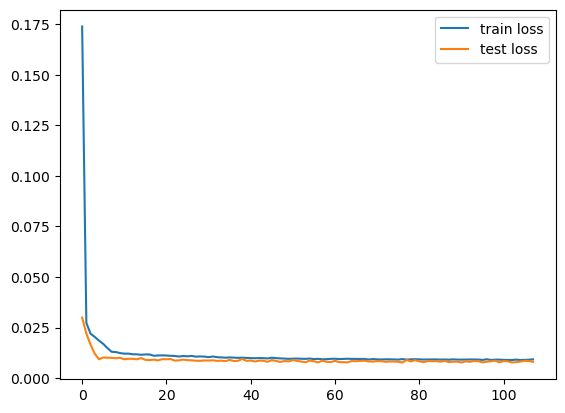

In [16]:
# Plot the learning curve
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [17]:
# Plot the comparison between measurements and predictions of the training data
### Your Code Here ###
pass

In [18]:
# Plot the comparison between measurements and predictions of the test data
### Your Code Here ###
pass

### Task 2: Wind Power Generation Forecasts using LSTM (Bonus)

In this exercise you need to implement an LSTM model to forecast wind power generation in the specific period based on the given 7 weather features.

**a)** Import wind farm time-series dataset **wf.hdf5** in the data folder. 

In [19]:
datastore = pd.HDFStore('./data/wf.hdf5')
data = datastore.get('windfarm')

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 620, in H5Fopen
    unable to open file
  File "H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "H5PLpath.c", line 620, in H5PL__path_table_iterate_process_path
    can't open directory: /opt/homebrew/anaconda3/envs/TSDM-env/lib/hdf5/plugin
  File "H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "H5Fint.c", line 1990, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 617, in H5F__super_read
    truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048

End of HDF5 error back trace

Unable to open/create file './data/wf.hdf5'

In [ ]:
data.head(5)

The windfarm dataset contains **hourly averaged wind power generation time series** for two consecutive years and **the corresponding day-ahead meteorological forecasts** using the European Centre for Medium-Range Weather Forecasts (ECMWF) weather model.

The data set contains the following data items:

- Time Stamp of the measurement
- Forecasting Time, Time between the creation of the forecast to the forecasted point in time
- Air Pressure of the measurement
- Air Temperature of the measurement
- Humidity
- Wind Speed in 100m height
- Wind Speed in 10m height
- Wind Direction (zonal) in 100m height
- Wind Direction (meridional) in 100m height
- Wind Power Generation of the wind farm

**The power generation time series are normalized** with the respective nominal capacity of the wind farm in order to enable a scale-free comparison and to mask the original characteristics of the wind farm. 

Additionally, **all weather situations are normalized in the range \[0..1\]**. 

The data set is pre-filtered to **discard any period of time longer than 24h in which no energy has been produced**, as this is an indicator of a wind farm malfunction.

**b)** Visualize the weather features and the power generation.

In [ ]:
for col in data.columns[2:]:
    plt.figure(figsize=(10,6))
    plt.plot(data[col].values[:1000])
    plt.title(col)
    plt.show()

**c)** Convert the wind farm time series to sequence-to-sequence training samples.
        
**Hints**:

- The dimension of input sequences should be $[N, 6, 7]$, where $N$ indicates the number of samples, 6 indicates the time steps of the input sequence, and 7 indicates the dimension of weather features.

- The dimension of an output sequnece should be $[N, 6, 1]$, where $N$ indicates the number of samples, 6 indicates the time steps of the target sequence, and 1 indicates the dimension of the target, i.e., wind power generation.

- The **discarded periods** should be considered while building sequence-to-squence samples. If the difference between the two successive time indices is greater than 1 hour, **print** and **store** the two successive time indices.

- You can compare your cleaned sequence data to the given data in 'clean_wf.hdf5'.

- If you have no idea how to implement the function **seq_2_seq**, you can directly use 'clean_wf.hdf5' to finish the following tasks.

In [ ]:
train, test = data[:12000], data[12000:]
seq_length = 6

In [ ]:
# Print the discarded periods in training dataset 
discarded_periods_train = []
discarded_periods_train.append(train.index[0])
print('discarded periods in training dataset:\n')
for idx_1, idx_0 in zip(train.index[1:], train.index[:-1]):
    # if the difference between two successive time indices is greater than 1 hour, print and store the time indices.     
    ### Your Code Here ###
    pass
    
discarded_periods_train.append(train.index[-1])


# Print the discarded periods in test dataset 
discarded_periods_test = []
discarded_periods_test.append(test.index[0])
print('\ndiscarded periods in test dataset:\n')
for idx_1, idx_0 in zip(test.index[1:], test.index[:-1]):
    # if the difference between two successive time indices is greater than 1 hour, print and store the time indices.
    ### Your Code Here ###
    pass
    
discarded_periods_test.append(test.index[-1])


In [ ]:
def seq_2_seq(data, discarded_periods, seq_length):
    '''
    Clean the discareded periods and convert the data to sequence-to-sequence data
    
    Inputs:
    data: pd.DataFrame, the raw data
    discareded_periods: list, which contains the interrupted time indices.
    seq_length: int, the sequence length of generated input and output data.
    
    '''
    data_seq2seq = pd.DataFrame([],columns=data.columns)
    for i in range(0,len(discarded_periods), 2):
        data_selected = data.loc[discarded_periods[i]:discarded_periods[i+1]]
        if data_selected.shape[0] < seq_length:
            continue
        
        for idx in range(data_selected.shape[0]-seq_length):
            # concatenate the successive samples with the given length to the data_seq2seq
            ### Your Code Here ###
            pass
 
    return data_seq2seq

In [ ]:
train_seq = seq_2_seq(train, discarded_periods_train, seq_length)

In [ ]:
train_seq.iloc[:14]

In [ ]:
test_seq = seq_2_seq(test, discarded_periods_test, seq_length)

In [ ]:
train_seq.iloc[:14]

You can compare your cleaned sequence data to the given data in 'clean_wf.hdf5'.

If you have no idea how to implement the function **seq_2_seq**, you can directly use 'clean_wf.hdf5' to finish the following tasks.

In [ ]:
# import the clean_wd,hdf5 if you can not implement the function seq_2_seq
# Otherwise, use the function seq_2_seq to generate seq-seq samples for training and test.
### Your Code Here ###
pass

In [ ]:
# Split the train_seq/test_seq to train_X and train_y/test_X and test_y with the size 
# [number of samples, sequence length, features(target)], and convert to torch.tensor (dtype=torch.float32).
### Your Code Here ###
pass

In [ ]:
print(f'size of train_X_tensor: {train_X_tensor.shape}')
train_X_tensor[0]

In [ ]:
print(f'size of test_X_tensor: {test_X_tensor.shape}')
test_X_tensor[0]

**d)** Complete the class of LSTM models.

The model contains [LSTM Layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), which is followed by a Linear layer.

In [ ]:
class lstm(nn.Module):
    
    def __init__(self, input_size=1, output_size=1, hidden_size=32, num_layers=1, dropout=0.2,
                 seq_length_in = 7, seq_length_out = 1, batch_first=True, random_init=True):
        super().__init__()
        '''
        Initialize the hyperparameters and the layers of the network, including lstm layers and a linear layer.
        input_size: int, dimension of the input features at each time step
        output_size: int, dimension of the target at each time step
        hidden_size: number of neuros in lstm layers
        num_layers: number of lstm layers
        dropout: dropout rate in lstm layers
        seq_length_in: the sequence length of input data
        seq_length_out: the sequence length of output (target) data
        batch_first: boolean, if true, the size of the input data should be: 
                     [batch_size (number of samples), sequence length, features(or targets)]
        random_init: boolean, if true, the initial hidden states and cell states of the lstm layers are sampled from a normal 
                     distribution; Otherwise, it is set to zero. 
        '''
        ### Your Code Here ###
        pass
        
    def forward(self, x):
        '''
        x: torch.tensor, the input
        
        Feedforward propagation of the input to the output.
        '''
        
        if self.batch_first:
            # get the batch size from the input x to create the initial hidden states h0 and cell states c0
            ### Your Code Here ###
            pass
        else:
            ### Your Code Here ###
            pass
        if self.random_init:
            ### Your Code Here ###
            pass
        else:
            ### Your Code Here ###
            pass
        
        # feedforward propagation of the input to the output 
        ### Your Code Here ###
        pass
        return x

**e)** Declare an lstm model and train it using the above function **training_process()**.


In [ ]:
# The hyperparameters
epochs = 256
hidden_size = 32
num_layers = 2
input_size = train_X_tensor.shape[2]
seq_length_in = train_X_tensor.shape[1]
output_size = train_y_tensor.shape[2]
seq_length_out = train_y_tensor.shape[1]
dropout_rate = 0.2
batch_size = 128
early_stop_patience = 30
batch_first = True
random_init = True

# Dataloader
dataset = TensorDataset(train_X_tensor, train_y_tensor)
loader = DataLoader(dataset, batch_size=batch_size)

In [ ]:
lstm_model = lstm(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers,
                  dropout=dropout_rate, seq_length_in = seq_length_in, seq_length_out = seq_length_out,
                  batch_first=batch_first, random_init=random_init)



# Define loss function
### Your Code Here ###
pass

# Define optimizer
### Your Code Here ###
pass

# Train the lstm model using the function training_process()
lstm_model, train_losses, test_losses = training_process(lstm_model, epochs, loader, optimizer_lstm, 
                                                         test_X_tensor, test_y_tensor, early_stop_patience)

In [ ]:
# Plot the comparison between measurements and predictions of the test data at the first time step, 
# i.e, plt.plot(test_y_tensor[:,0,:])
### Your Code Here ###
pass

In [ ]:
# Calculate the error of each time step. 
### Your Code Here ###
pass